# Time-Series Forecasting | Corporación Favorita Grocery Sales
## Section 4: SARIMA
### 1 - Notebook Overview

This notebook implements a **SARIMA (Seasonal AutoRegressive Integrated Moving Average)** model to forecast daily unit sales for the `Guayas` region. While [Section 3: Model - XGBoost with Hyperparameter Tuning](/notebooks/03-model-xgboost.ipynb) utilized a machine learning approach (**XGBoost**), I now apply a classic statistical method to serve as a benchmark.

As identified in [Section 2: Exploratory Data Analysis](/notebooks/02-exploratory-data-analysis.ipynb), the dataset exhibits a definite and strong weekly seasonality, with significant sales spikes occurring every weekend. Although the data showed marginal non-stationarity, **SARIMA** is specifically chosen for its ability to handle these patterns through:

- **Differencing ($d$):** To stabilize the mean by removing trends.
- **Seasonality ($S$):** To explicitly model the weekly cycles (7-day periods) found in the retail environment.

By comparing this statistical baseline against the **XGBoost** results, I can determine if the complexity of machine learning provides a significant uplift in forecasting accuracy.

---

### 2 - Import Libraries

In [12]:
# Core libraries
import pandas as pd
import numpy as np
import time

# Data visualization
import matplotlib.pyplot as plt

# Machine learning libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### 3 - Data Ingestion

In [2]:
# Load the cleaned dataset
df_train = pd.read_pickle('../data/train_models.pkl')

# Check shape
print(f"Shape: {df_train.shape}")

# Check memory usage
memory_gb = df_train.memory_usage(deep=True).sum() / (1024**3)
print(f"Memory: {memory_gb:.2f} GB")

# Check column data types
print("\nColumn Data Types:")
print("-" * 50)
print(df_train.dtypes)

# Check for missing values
print("\nMissing Values per Column:")
print("-" * 50)
display(df_train.isnull().sum())

# Display first 3 rows
print("\nDataset Preview:")
print("-" * 50)
display(df_train.head(3))

Shape: (18680367, 15)
Memory: 1.67 GB

Column Data Types:
--------------------------------------------------
date                  datetime64[ns]
store_nbr                      int32
item_nbr                       int32
unit_sales                   float64
onpromotion                    int32
year                           int32
month                          int32
day                            int32
day_of_week                    int32
is_holiday                     int32
unit_sales_7d_avg            float64
unit_sales_14d_avg           float64
unit_sales_lag_1             float64
unit_sales_lag_7             float64
unit_sales_lag_30            float64
dtype: object

Missing Values per Column:
--------------------------------------------------


date                  0
store_nbr             0
item_nbr              0
unit_sales            0
onpromotion           0
year                  0
month                 0
day                   0
day_of_week           0
is_holiday            0
unit_sales_7d_avg     0
unit_sales_14d_avg    0
unit_sales_lag_1      0
unit_sales_lag_7      0
unit_sales_lag_30     0
dtype: int64


Dataset Preview:
--------------------------------------------------


,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,is_holiday,unit_sales_7d_avg,unit_sales_14d_avg,unit_sales_lag_1,unit_sales_lag_7,unit_sales_lag_30
30,2013-07-08,24,96995,0.0,0,2013,7,8,0,0,0.0,0.0,0.0,0.0,2.0
31,2013-07-09,24,96995,0.0,0,2013,7,9,1,0,0.0,0.0,0.0,0.0,0.0
32,2013-07-10,24,96995,0.0,0,2013,7,10,2,0,0.0,0.0,0.0,0.0,0.0


### 4 - Data Aggregation & Time-Series Slicing

Because **SARIMA** is a univariate model, I am aggregting the item-level data into a single daily total for the `Guayas` region. I am then splitting the data chronologically to match the **XGBoost** notenook by training on 2013 sales and testing on Q1 2014.

In [6]:
# Aggregate to daily totals for the region
df_daily = df_train.groupby('date')['unit_sales'].sum().to_frame()

# Re-confirming frequency for SARIMA stability
df_daily = df_daily.asfreq('D')

# Define 2014 forecast dates
start_date = '2014-01-01'
end_date = '2014-03-31'

# Create training datset of 2013 data
train_data = df_daily[:'2013-12-31'].copy()

# Create validation dataset of first quarter 2014 data
val_data = df_daily[start_date:end_date].copy()

# Check shapes of training and validation datasets
print("TRAINING DATASET")
print("-" * 50)
print(f"Shape: {train_data.shape}")
print("Start date:", train_data.index.min().date())
print("End date:", train_data.index.max().date())
print("Preview:")
display(train_data.head(3))
print("\nVALIDATION DATASET")
print("-" * 50)
print(f"Shape: {val_data.shape}")
print("Start date:", val_data.index.min().date())
print("End date:", val_data.index.max().date())
print("Preview:")
display(val_data.head(3))

TRAINING DATASET
--------------------------------------------------
Shape: (334, 1)
Start date: 2013-02-01
End date: 2013-12-31
Preview:


,unit_sales
date,
2013-02-01,15.0
2013-02-02,14.0
2013-02-03,40.0



VALIDATION DATASET
--------------------------------------------------
Shape: (90, 1)
Start date: 2014-01-01
End date: 2014-03-31
Preview:


,unit_sales
date,
2014-01-01,7.0
2014-01-02,1059.0
2014-01-03,794.0


### 5 - SARIMA Model Training

I am applying a **SARIMA(1, 1, 1) x (1, 1, 1, 7)** configuration:

- **(1, 1, 1):** This handles the general direction and "momentum" of the sales.
- **(1, 1, 1, 7):** This explicitly models the weekly seasonality (7 days) as observed in the EDA. 

In [7]:
# Record the start time
start_time = time.time()

# Define and Fit Model
model = SARIMAX(
    train_data['unit_sales'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = model.fit(disp=False)

# Record the end time
end_time = time.time()

# Calculate training time
training_duration = end_time - start_time

### 6 - Forecasting

The model is asked to predict the first 90 days of 2014 including a **Confidence Interval**, which shows the "uncertainty range" of the statistical model.

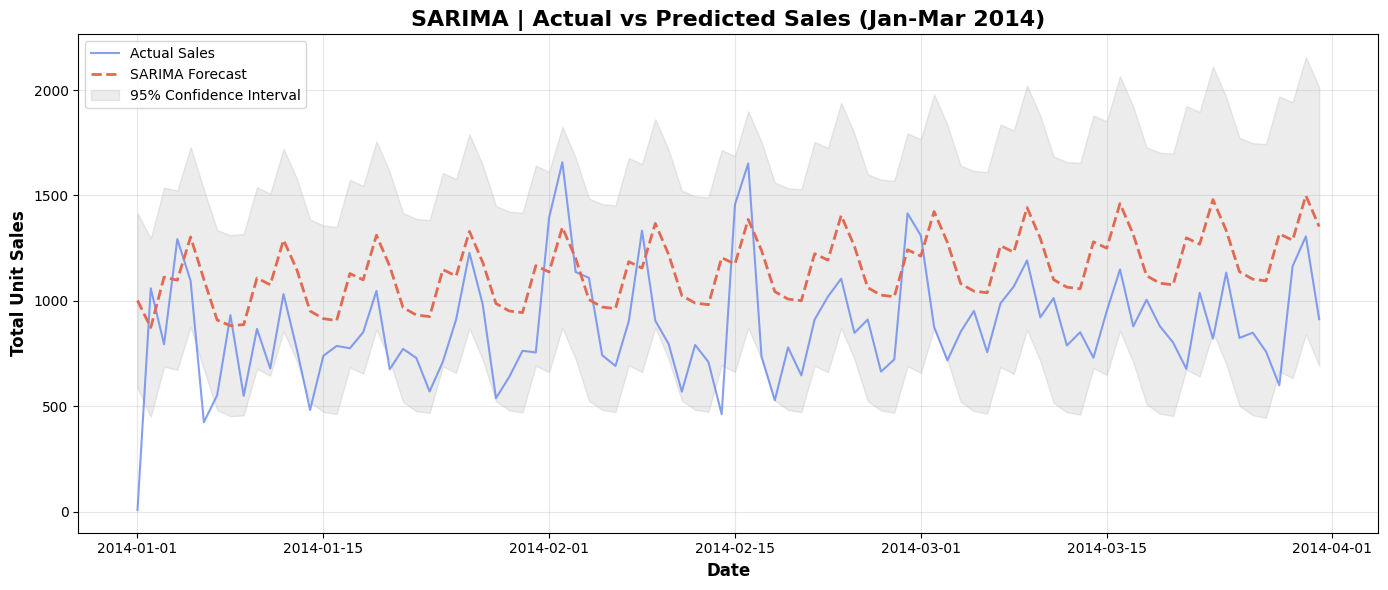

In [9]:
# Generate forecast for the length of val_data (90 days)
forecast_obj = sarima_results.get_forecast(steps=len(val_data))
y_pred = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

# Plot Actuals vs Predicted with Confidence Intervals
plt.figure(figsize=(14, 6))
plt.plot(val_data.index, val_data['unit_sales'], label='Actual Sales', color='#6788ee', alpha=0.8)
plt.plot(val_data.index, y_pred, label='SARIMA Forecast', color='#e26952', linewidth=2, linestyle='--')

# Shading the uncertainty
plt.fill_between(val_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.15, label='95% Confidence Interval')

# Add titles and labels
plt.title('SARIMA | Actual vs Predicted Sales (Jan-Mar 2014)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Total Unit Sales', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure
plt.savefig('../visualizations/sarima-actual-vs-predicted.png', dpi=300)

# Display the plot
plt.show()

### 7 - Evaluation Metrics

In [11]:
# Calculate evaluation metrics
mae = mean_absolute_error(val_data['unit_sales'], y_pred)
mse = mean_squared_error(val_data['unit_sales'], y_pred)
rmse = np.sqrt(mse)
bias = np.mean(y_pred - val_data['unit_sales'])
r2 = r2_score(val_data['unit_sales'], y_pred)

print("SARIMA Model Evaluation Metrics")
print("-" * 50)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Bias: {bias:.2f}")
print(f"R-Squared Score: {r2:.2f}")

# Print training time
minutes = int(training_duration // 60)
seconds = int(training_duration % 60)
print(f"Training Time: {minutes:02d}:{seconds:02d}")

SARIMA Model Evaluation Metrics
--------------------------------------------------
Mean Absolute Error (MAE): 312.04
Mean Squared Error (MSE): 124868.58
Root Mean Squared Error (RMSE): 353.37
Bias: 265.47
R-Squared Score: -0.74
Training Time: 00:00


### 10 - Conclusion

The **SARIMA (1, 1, 1) x (1, 1, 1, 7)** model was implemented to provide a classic statistical benchmark for the total daily sales in the Guayas region. General Conclusions:

- **Systematic Over-prediction (Bias):** The model shows a significant **Bias of 265.47**, indicating that it consistently over-predicted sales for the Q1 2014 period. This suggests that the sales momentum from late 2013 did not carry over into the new year at the expected levels, and the model failed to "correct" downward.
- **Accuracy and Seasonality:** While the **MAE of 312.04** is large, it represents the error for the *entire region's daily sum*. The negative **R-Squared (-0.74)** confirms that the model's predictions are less accurate than a simple average. This highlights that while SARIMA is excellent at following a 7-day "rhythm," it struggles to find the correct "altitude" for the sales volume.
- **The Value of Machine Learning:** Comparing these results to the XGBoost model demonstrates the necessity of the ML approach. The XGBoost model's inclusion of item-level features and promotional data allowed it to remain much closer to the actual values (Bias of 0.01) compared to this trend-based statistical approach.

For the `Guayas` region, relying solely on historical sales patterns (univariate analysis) is insufficient for accurate inventory planning. The exogenous factors used in the **XGBoost** model, such as promotional activity and short-term rolling averages, are critical for capturing the actual variance of the Ecuadorian retail market.